# BloqadeNoisy tutorial
B. McDonough

QuEra Computing Inc.

*Stochastic wavefunction simulator written for Bloqade*

In [ ]:
using BloqadeNoisy #import BloqadeNoisy
using Bloqade
using Yao
using LaTeXStrings
using LinearAlgebra
using Kronecker


using Plots
pythonplot()

## Background

### The Lindblad master equation
Open quantum systems in the limit of ultraweak coupling to a Markovian bath can be modelled using the Lindblad master equation:
$$
\frac{\partial \rho}{\partial t} = i[\rho, \mathcal H_{eff}] + \sum_{k}\gamma_k L_k\rho L_k^\dagger
$$
where $\mathcal H_{eff}$ is the effective Hamiltonian, $L_k$ are the quantum jump operators, and $\gamma_k$ are the jump rates. The jump operators describe the coupling to the bath, and they are without loss of generality taken to be traceless. The effective Hamiltonian is non-Hermitian and is related to the closed-system Hamiltonian $\mathcal H$ via $\mathcal H_{eff} = \mathcal H-\frac{i}{2}\sum_{k}\gamma_k L_k^\dagger L_k$. 

### Unraveling the master equation
The infinitesimal form of this channel can be put into Kraus map form as
$$
\rho(t+dt) = (1-i dt \mathcal H_{eff})\rho(t) (1+i dt \mathcal H_{eff}) + dt\sum_{k}\gamma_k L_k \rho(t) L_k^\dagger
$$
This corresponds to a quantum jump $L_k$ with probability $dp_k = dt\gamma_k\operatorname{Tr}(L_k \rho L_k^\dagger)$. If $\rho = |\psi\rangle\langle \psi|$ is a (normalized) pure state, then $dp_k = dt \gamma_k \Vert L_k|\psi\rangle\Vert^2$, the norm of the state after undergoing the quantum jump. With probability $1-dp$ where $dp = \sum_k dp_k$ is the total probability of experencing a quantum jump, the system evolves to $(1-i dt \mathcal H_{eff})\rho (1+i dt \mathcal H_{eff}) \approx \rho + i dt[\rho, \mathcal H_{eff}]$. This corresponds to the normal Liouville-Von Neumann equation with the non-Hermitian effective Hamiltonian $\mathcal H_{eff}$. The physical interpretation of this is that an absence of a quantum jump also has an affect on the system evolution.

These dynamics can be modeled stochastically by chopping the evolution into small intervals $dt$. At each time step, the state $|\psi\rangle$ evolves to $\frac{1}{\mathcal N}(1-idt\mathcal H_{eff})|\psi \rangle$ with probability $1-dp$ and evolves to $\frac{1}{\mathcal N}L_k |\psi \rangle$ with probability $dp_k$, where $\frac{1}{\mathcal N}$  is the appropriate normalization. Performing this stochastic evolution results in a single trajectory consisting of a number of random quantum jumps at random times. Averaging over $j \in \{1,...,m\}$ trajectories results in an ensemble of state $|\psi_j(t)\rangle$, and averaging $|\psi_j\rangle\langle\psi_j|$ over these trajectories converges to the density matrix $\rho$ produced by noisy evolution in the limit as $m\to \infty$.

### Algorithm
In practice directly modeling the stochastic process described above is computationally inefficient. Noticing that 
$$
\Vert(1-idt\mathcal H_{eff})|\psi \rangle\Vert^2 = 1 - \sum_k \gamma_k\langle \psi| L_k^\dagger L_k |\psi\rangle = 1 - dp \ ,
$$
the change in the wavefunction norm over an interval of coherent evolution is related to the accumulation of probability $p$ of experiencing a quantum jump. The result is the following algorithm:
1. Choose a random number $r$
2. Evolve according to $\frac{\partial}{\partial t}|\psi\rangle = -i\mathcal H_{eff}|\psi\rangle$ without normalizing the state
3. When $\Vert |\psi\rangle \Vert^2 = r$, trigger a quantum jump $k$ according to the distribution $p_k \equiv dp_k/\sum_k dp_k$ and normalize

### Further reading
For a more in-depth description of the algorithm, please refer to the following resources:

[1] https://qutip.org/docs/latest/guide/dynamics/dynamics-monte.html

[2] https://lukin.physics.harvard.edu/files/lukin/files/physics_285b_lecture_notes.pdf (Chapter 6)

## BloqadeNoisy workflow

In [ ]:
#pre-built noise model
noise_model = Aquila()

In [3]:
reg = zero_state(1)
h = rydberg_h([(0,0)], Ω = 15, Δ = 0)
save_times = LinRange(0, 10, 500) #choose the times at which to save the solution

ns = NoisySchrodingerProblem(reg, save_times, h, Aquila())
#Pretty printing!

NoisySchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 10.0)

  equation: 
    storage size: 40 bytes
    expression:
nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] 2π ⋅ 1.19 ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


collapse operators: 1
    algorithm: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))


In [5]:
sim = emulate(ns, 2000) #default output is the average probability amplitudes in the computational basis

500-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [0.9775539979895759, 0.02244600201042494]
 [0.9122806419633569, 0.087719358036643]
 [0.8101171759698717, 0.189882824030128]
 [0.680270639666862, 0.3197293603331367]
 [0.5344648815197895, 0.4655351184802106]
 [0.38577012897005486, 0.6142298710299446]
 [0.2477071796092315, 0.7522928203907688]
 [0.13300917515944924, 0.8669908248405511]
 [0.05149913650968733, 0.9485008634903127]
 ⋮
 [0.49638588699390385, 0.503614113006096]
 [0.4975859868063422, 0.5024140131936579]
 [0.49903035237493815, 0.5009696476250618]
 [0.5005626963848246, 0.49943730361517524]
 [0.5020843795790265, 0.49791562042097365]
 [0.5034128230692004, 0.4965871769307995]
 [0.5045247124561558, 0.49547528754384423]
 [0.5052475954933534, 0.4947524045066465]
 [0.5054316200274352, 0.4945683799725648]

In [7]:
end_state = last(sim)

2-element Vector{Float64}:
 0.5054316200274352
 0.4945683799725648

In [8]:
println(measure_noisy(noise_model, end_state))
#Make 10000 noisy measurements of the above state and average
measure_noisy(noise_model, end_state; nshots = 100)

DitStr{2, 1, Int64}[0 ₍₂₎]


100-element Vector{DitStr{2, 1, Int64}}:
 0 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎
     ⋮
 1 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎

## Expectation values

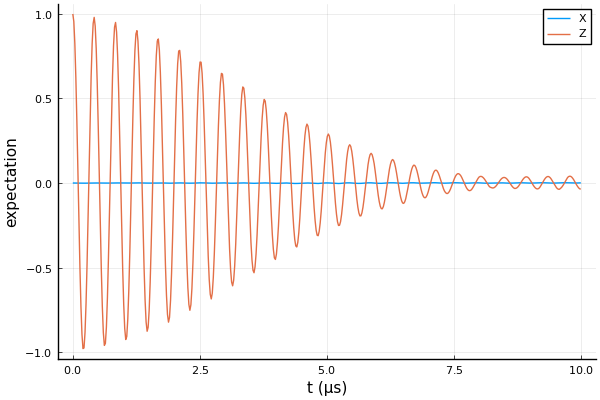

In [9]:
#Get expectation values
sim = emulate(ns, 1000, mat.([X,Z]))
plot(save_times, sim[1], label = "X", xlabel = "t (µs)", ylabel = "expectation")
plot!(save_times, sim[2], label = "Z")
current()

### Readout noise

0.98

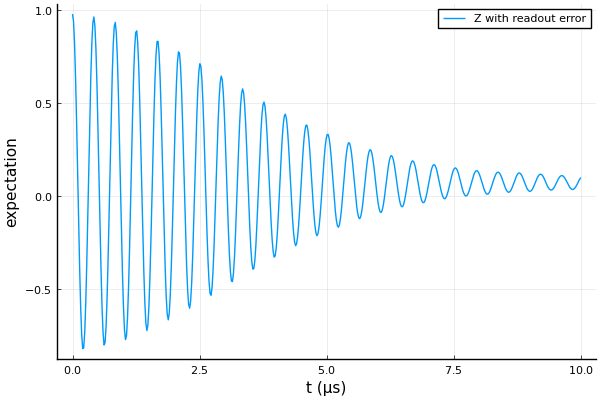

In [10]:
#For operators in the computational basis, readout noise can also be incorporated
sim = emulate(ns, 2000, [mat(Z)]; readout_error = true)
print(sim[1][1]) #.98 = .99 - .01 reflecting .01 probability of confusing ground with Rydberg
plot(save_times, sim[1], label = "Z with readout error", xlabel = "t (µs)", ylabel = "expectation")

### Estimating accuracy

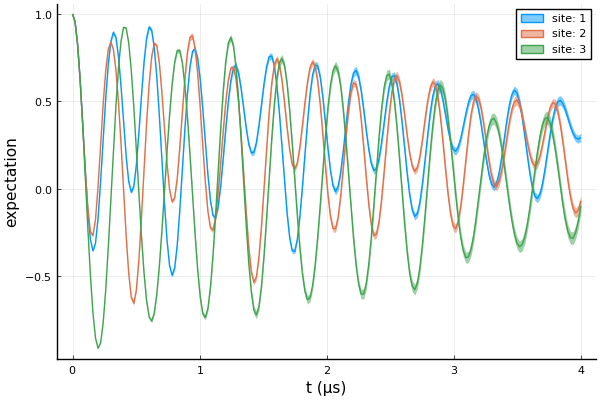

In [11]:
#Error estimation
#The error from a finite number of trajectories can also be estimated:
reg = zero_state(3)
h = rydberg_h([(0,0), (8,0), (18,0)], Ω = 15, Δ = 0)
save_times = LinRange(0, 4, 200) #choose the times at which to save the solution

ns = NoisySchrodingerProblem(reg, save_times, h, Aquila())
sim = emulate(ns, 500, [mat(put(3, i=>Z)) for i in 1:3]; report_error = true)
plot(xlabel = "t (µs)", ylabel = "expectation")
for i in 1:3
    plot!(save_times, sim.expectations[i], ribbon = sim.twosigma[i], label = "site: $i")
end
current()

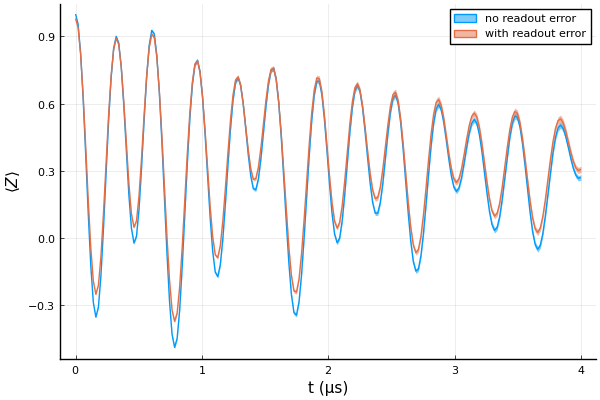

In [12]:
#add readout noise to an expectation value and estimate the error
sim = emulate(ns, 2000, [mat(put(3, 1=>Z))]; report_error = true)
sim_ro = emulate(ns, 2000, [mat(put(3, 1=>Z))]; readout_error = true, report_error = true)

plot(save_times, sim.expectations[1], ribbon = sim.twosigma[1], label = "no readout error", xlabel = "t (µs)", ylabel = L"\langle Z \rangle")
plot!(save_times, sim_ro.expectations[1], ribbon = sim_ro.propagated_error[1], label = "with readout error") #Gaussian error propagation

## Eperimental shots
The number of shots can be restricted without changing the number of trajectories to simulate an experimental setting.

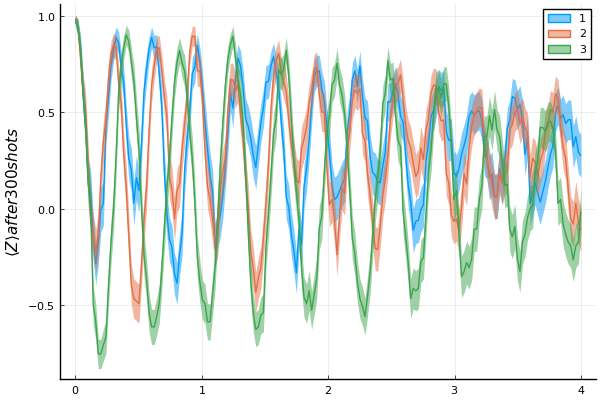

In [13]:
#For observables that are diagonal in the computational basis, the value after a finite number of experimental
#shots can also be simulated with error

sim = emulate(ns, 500, [mat(put(3, i=>Z)) for i in 1:3]; readout_error = true, report_error = true, shots = 300)
plot(xlable = "t (µs)", ylabel = L"\langle Z \rangle after 300 shots")
for i in 1:3
    plot!(save_times, sim.expectations[i], ribbon = sim.shot_error[i], label = "$i")
end
current()

In [14]:
#If desired, noisy experimental shots can be simulated directly:
sim = emulate(ns, 500)
t = save_times[100] #arbitrary
measure_noisy(Aquila(), sim[100]; nshots = 10)

1.9899497487437185


10-element Vector{DitStr{2, 3, Int64}}:
 110 ₍₂₎
 100 ₍₂₎
 000 ₍₂₎
 001 ₍₂₎
 011 ₍₂₎
 010 ₍₂₎
 000 ₍₂₎
 010 ₍₂₎
 011 ₍₂₎
 000 ₍₂₎

## Code injection

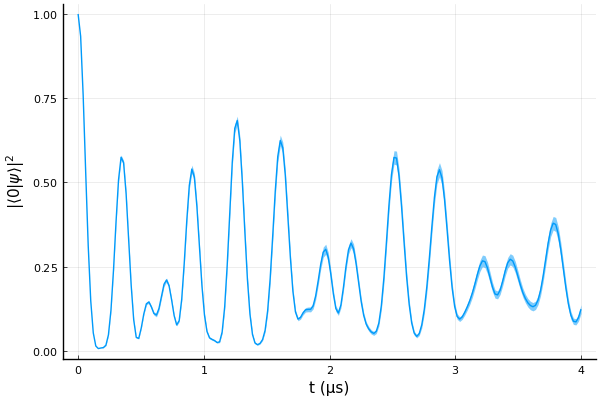

In [15]:
#For custom output, emulate can be called with an output function that transforms the (normalized) solution
sim = emulate(ns, 500, sol -> [abs(u[1])^2 for u in sol])
values = simulation_series_mean(sim) #convenience method for taking the mean over the trajectories
error = simulation_series_err(sim) #estimate the error based on the sampling variance
plot(save_times, values, ribbon = error, xlabel = "t (µs)", ylabel = L"|\langle 0 |ψ\rangle|^2", label = "")

In [16]:
#If more custom control is desired, then an EnsembleProblem can be created directly with the following:
using DifferentialEquations
randomize(ns) #samples a new trajectory with a modified Hamiltonian and different initial conditions
ep = EnsembleProblem(ns, prob_func = (prob, i, repeat)->randomize(ns))
solve(ep, trajectories = 10)

EnsembleSolution Solution of length 10 with uType:
ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, NoisySchrodingerProblem{ArrayReg{2, ComplexF64, Matrix{ComplexF64}}, ODEFunction{true, SciMLBase.FullSpecialize, NoisySchrodingerEquation{SparseMatrixCSC{ComplexF64, Int64}}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{ComplexF64}, Tuple{Float64, Float64}, DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Base.Pairs{Symbol, Any, NTuple{6, Symbol}, NamedTuple{(:save_everystep, :dense, :reltol, :abstol, :saveat, :callback), Tuple{Bool, Bool, Float64, Float64, LinRange{Float64, Int64}, ContinuousCallback{typeof(BloqadeNoisy.collapse_condition), BloqadeNoisy.var"#30#33"{Vector{SparseMatrixCSC{ComplexF64

In [8]:
# Custom noise models
# A custom incoherent noise model can be implemented by specifying the collapse operators
rate = 1/10
reg = zero_state(1)
c_ops = [sqrt(rate)*mat((X+im*Y)/2)] #this noise model will not have any coherent error
h = rydberg_h([(0,0)], Ω = 15)
ns = NoisySchrodingerProblem(reg, save_times, h, c_ops)

NoisySchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 4.0)

  equation: 
    storage size: 40 bytes
    expression:
nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
└─ [+] 2π ⋅ 1.19 ⋅ ∑ σ^x_i


collapse operators: 1
    algorithm: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))


In [119]:
#A custom coherent noise mode
#Cutom coherent and readout noise models can be implemented using the following interface
trivial_error_model = ErrorModel(
    n -> I,
    n -> [],
    h -> (() -> h)
)

ErrorModel(var"#269#273"(), var"#270#274"(), var"#271#275"())

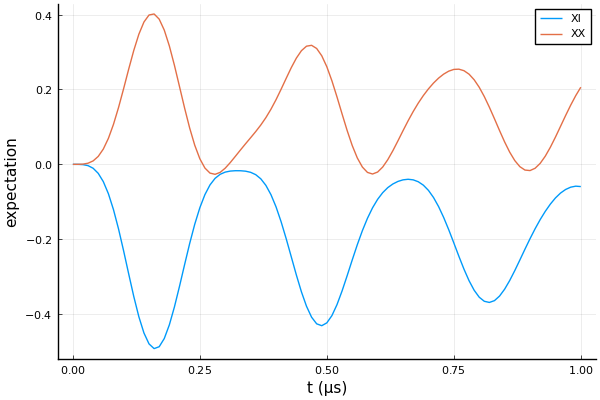

In [106]:
#A more complicated error model would look like the following:
confusion_matrix(n) = kronecker([[[.9 .1];[.1 .9]] for i in 1:n]...)
bitflip_model(n) = [SparseMatrixCSC(sqrt(1/10)*mat(put(n, i=>X))) for i in 1:n]
coherent_noise(h) = () -> ((atoms,ϕ,Ω,Δ)=get_rydberg_params(h); rydberg_h(atoms; Ω = Ω*(1+.08*randn()), Δ = Δ, ϕ = ϕ))

better_error_model = ErrorModel(
    confusion_matrix,
    bitflip_model,
    coherent_noise
)

ns = NoisySchrodingerProblem(zero_state(2), 0:1f-2:1, rydberg_h([(0,),(8)]; Ω = 15), better_error_model)
sim = emulate(ns, 1000, [mat(put(2, 1=>X)), mat(kron(X, X))])
plot(0:1f-2:1, sim[1], label = "XI", xlabel = "t (µs)", ylabel = "expectation")
plot!(0:1f-2:1, sim[2], label = "XX")